# Import Python Libraries

In [2]:
# import needed libraries
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
from sklearn.utils import shuffle
import csv
import os
import math

In [3]:
from utility import *
import keras
from keras.models import Sequential 
from keras.layers import Input, Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout

# Load Data Set

In [4]:
#load data in form of np array
data_b = np.load('images_benign_50.npy')
print("# benign:", data_b.shape)

data_m = np.load('images_mali_50.npy')
print("# malignant:", data_m.shape) 

dim = int(math.sqrt(data_b.shape[1] / 3 )) # dimension of the image
print("dimension of images:", dim)

# benign: (8061, 7500)
# malignant: (1954, 7500)
dimension of images: 50


In [5]:
#vertically stack files
data = np.vstack((data_b,data_m))
print("original data shape:", data.shape)

# create labelset (benign = 1, malignant = 2)
label_b = np.ones((data_b.shape[0],1),dtype=np.uint8) # an array of all zeros
label_m = np.ones((data_m.shape[0],1),dtype=np.uint8) * 2 # an array of all ones
label = np.vstack((label_b,label_m)) # all label

original data shape: (10015, 7500)


## train test separation

In [6]:
data_train, label_train, data_test, label_test = train_test_shuffled_separation(data, label, train_percent= 0.8)

shuffled data shape: (10015, 7500) shuffled label shape: (10015,)
# train: 8012
# test:  2003
# total: 10015


## convert label (1/2) to one hot code

In [7]:
label_train = label_to_one_hot(label_train)
label_test = label_to_one_hot(label_test)

## reshape image arrays to N x size x size x 3

In [8]:
data_train = data_train.reshape((data_train.shape[0], dim, dim, 3))
data_test = data_test.reshape((data_test.shape[0], dim, dim, 3))

## normalize image arrays to 0 - 1 

In [9]:
data_train = normalize_data(data_train)
data_test = normalize_data(data_test)
print("image size:", data_train.shape[1:])

image size: (50, 50, 3)


# Display images from dataset

In [10]:
# function to display the images
def list_images(data, label, ylabel="", cmap=None):
    plt.figure(figsize=(15, 16))
    
    for i in range(6):
        plt.subplot(1, 6, i+1)
        indx = random.randint(0, len(data))
        
        #Use gray scale color map if there is only one channel
        cmap = 'gray' if len(data[indx].shape) == 2 else cmap
        plt.imshow(data[indx], cmap = cmap)
        
        plt.xlabel("Benign" if label[indx][0] == 1 else "Malignant")
        #plt.ylabel(ylabel)
        
        plt.xticks([])
        plt.yticks([])
    #plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

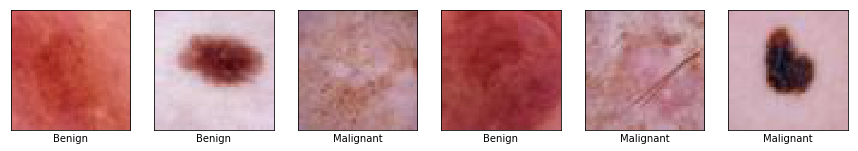

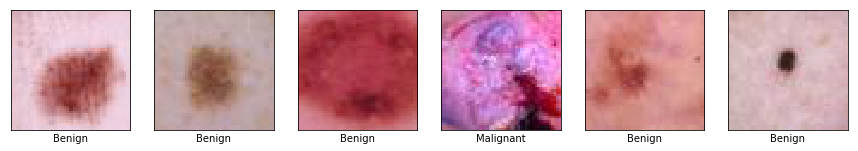

In [11]:
# plot the sample images
list_images(data_train, label_train)
list_images(data_test, label_test)

# Data Preprocessing

In [12]:
# convert images to gray scale
def gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# VGG-13 implemented in keras

In [13]:
VGG13_model = Sequential()

#  input dimension is (dim, dim, 3)
#  block 1: 2x Conv + Maxpool
# 3 -> 32 feature maps
VGG13_model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(dim, dim, 3), name='block1_conv1'))
VGG13_model.add(Conv2D(32, (3,3), activation='relu', padding='same', name='block1_conv2' ))
VGG13_model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2), name='block1_pool'))

# block 2: 2x Conv + Maxpool
# 32 -> 64 feature maps
VGG13_model.add(Conv2D(64, (3,3), activation='relu', padding='same', name='block2_conv1'))
VGG13_model.add(Conv2D(64, (3,3), activation='relu', padding='same', name='block2_conv2' ))
VGG13_model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2), name='block2_pool'))
VGG13_model.add(Dropout(0.25)) # dropout = 0.25

# block 3: 2x Conv + Maxpool
# 64 -> 128 feature maps
VGG13_model.add(Conv2D(128, (3,3), activation='relu', padding='same', name='block3_conv1'))
VGG13_model.add(Conv2D(128, (3,3), activation='relu', padding='same', name='block3_conv2' ))
VGG13_model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2), name='block3_pool'))

# block 4: 2x Conv + Maxpool
# 128 -> 256 feature maps
VGG13_model.add(Conv2D(256, (3,3), activation='relu', padding='same', name='block4_conv1'))
VGG13_model.add(Conv2D(256, (3,3), activation='relu', padding='same', name='block4_conv2' ))
VGG13_model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2), name='block4_pool'))

# block 5: 2x Conv + Maxpool
# 256 -> 256 feature maps
VGG13_model.add(Conv2D(256, (3,3), activation='relu', padding='same', name='block5_conv1'))
VGG13_model.add(Conv2D(256, (3,3), activation='relu', padding='same', name='block5_conv2' ))
VGG13_model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2), name='block5_pool'))

# block 6: 3x FC
VGG13_model.add(Flatten(name='block6_flatten'))
VGG13_model.add(Dense(2048, activation='relu', name='block6_fc1'))
VGG13_model.add(Dropout(0.5)) # dropout = 0.5
VGG13_model.add(Dense(2048, activation='relu', name='block6_fc2'))
VGG13_model.add(Dropout(0.5)) # dropout = 0.5
VGG13_model.add(Dense(2, activation='sigmoid', name='predictions')) # output two classes

### compile the VGG-13 architecture

In [14]:
# optimizer
# Adam
# AdaDelta
# SGD
SGD = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
VGG13_model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
data_train.shape

(8012, 50, 50, 3)

In [71]:
from __future__ import print_function
def visualize_cnn(layer):
    '''Visualization of the filters of VGG16, via gradient ascent in input space.

    This script can run on CPU in a few minutes.

    Results example: http://i.imgur.com/4nj4KjN.jpg
    '''
    

    import numpy as np
    import time
    from keras.preprocessing.image import save_img
    from keras.applications import vgg16
    from keras import backend as K

    # dimensions of the generated pictures for each filter.
    img_width = 50
    img_height = 50

    # the name of the layer we want to visualize
    # (see model definition at keras/applications/vgg16.py)
    layer_name = layer

    # util function to convert a tensor into a valid image


    def deprocess_image(x):
        # normalize tensor: center on 0., ensure std is 0.1
        x -= x.mean()
        x /= (x.std() + K.epsilon())
        x *= 0.1

        # clip to [0, 1]
        x += 0.5
        x = np.clip(x, 0, 1)

        # convert to RGB array
        x *= 255
        if K.image_data_format() == 'channels_first':
            x = x.transpose((1, 2, 0))
        x = np.clip(x, 0, 255).astype('uint8')
        return x

    def normalize(x):
        # utility function to normalize a tensor by its L2 norm
        return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())

    # build the VGG16 network with ImageNet weights
    model = vgg16.VGG16(weights='imagenet', include_top=False)
    print('Model loaded.')

    model.summary()

    # this is the placeholder for the input images
    input_img = model.input

    #print(input_img.shape)
    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])


    kept_filters = []
    for filter_index in range(10):
        # we only scan through the first 10 filters,
        # but there are actually 512 of them
        print('Processing filter %d' % filter_index)
        start_time = time.time()

        # we build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        layer_output = layer_dict[layer_name].output
        if K.image_data_format() == 'channels_first':
            loss = K.mean(layer_output[:, filter_index, :, :])
        else:
            loss = K.mean(layer_output[:, :, :, filter_index])

        # we compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, input_img)[0]

        # normalization trick: we normalize the gradient
        grads = normalize(grads)

        # this function returns the loss and grads given the input picture
        iterate = K.function([input_img], [loss, grads])

        # step size for gradient ascent
        step = 1.


        input_img_data = data_train[0:3]
        print(input_img_data.shape)

        #print(input_img_data.shape)

        # we run gradient ascent for 20 steps
        for i in range(20):
            loss_value, grads_value = iterate([input_img_data])
            input_img_data += grads_value * step

            print('Current loss value:', loss_value)
            if loss_value <= 0.:
                # some filters get stuck to 0, we can skip them
                break

        # decode the resulting input image
        if loss_value > 0:
            img = deprocess_image(input_img_data[0])
            kept_filters.append((img, loss_value))
        end_time = time.time()
        print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

    # we will stich the best 64 filters on a 8 x 8 grid.
    ## n has been changed from 8 to 2.
    n = 2

    # the filters that have the highest loss are assumed to be better-looking.
    # we will only keep the top 64 filters.
    kept_filters.sort(key=lambda x: x[1], reverse=True)
    kept_filters = kept_filters[:n * n]

    # build a black picture with enough space for
    # our 8 x 8 filters of size 128 x 128, with a 5px margin in between
    margin = 5
    width = n * img_width + (n - 1) * margin
    height = n * img_height + (n - 1) * margin
    stitched_filters = np.zeros((width, height, 3))

    # fill the picture with our saved filters
    for i in range(n):
        for j in range(n):
            img, loss = kept_filters[i * n + j]
            width_margin = (img_width + margin) * i
            height_margin = (img_height + margin) * j
            stitched_filters[
                width_margin: width_margin + img_width,
                height_margin: height_margin + img_height, :] = img
    return stitched_filters
    # save the result to disk
    #save_img('stitched_filters_%dx%d%s.png' % (n, n, layer), stitched_filters)

Model loaded.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0      

Current loss value: 15328.6
Current loss value: 15338.8
Current loss value: 15349.1
Current loss value: 15359.3
Current loss value: 15369.5
Filter 8 processed in 1s
Processing filter 9
(3, 50, 50, 3)
Current loss value: 6916.64
Current loss value: 6920.75
Current loss value: 6924.98
Current loss value: 6929.18
Current loss value: 6933.4
Current loss value: 6937.62
Current loss value: 6941.83
Current loss value: 6946.05
Current loss value: 6950.27
Current loss value: 6954.49
Current loss value: 6958.71
Current loss value: 6962.92
Current loss value: 6967.14
Current loss value: 6971.37
Current loss value: 6975.6
Current loss value: 6979.84
Current loss value: 6984.08
Current loss value: 6988.32
Current loss value: 6992.56
Current loss value: 6996.81
Filter 9 processed in 1s
Model loaded.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_55 (InputLayer)        (None, None, None, 3)     0         
_____

Current loss value: 18285.1
Current loss value: 18301.4
Current loss value: 18317.8
Current loss value: 18334.3
Current loss value: 18350.7
Current loss value: 18367.2
Current loss value: 18383.7
Current loss value: 18400.2
Current loss value: 18416.6
Current loss value: 18433.2
Filter 8 processed in 1s
Processing filter 9
(3, 50, 50, 3)
Current loss value: 8572.38
Current loss value: 8579.06
Current loss value: 8590.5
Current loss value: 8601.94
Current loss value: 8613.44
Current loss value: 8625.25
Current loss value: 8637.35
Current loss value: 8649.59
Current loss value: 8661.88
Current loss value: 8674.26
Current loss value: 8686.81
Current loss value: 8699.38
Current loss value: 8711.98
Current loss value: 8724.61
Current loss value: 8737.28
Current loss value: 8749.97
Current loss value: 8762.66
Current loss value: 8775.41
Current loss value: 8788.17
Current loss value: 8800.95
Filter 9 processed in 1s
Model loaded.
______________________________________________________________

Current loss value: 7476.46
Current loss value: 7507.54
Current loss value: 7538.87
Current loss value: 7570.33
Current loss value: 7601.83
Current loss value: 7633.35
Current loss value: 7664.9
Current loss value: 7696.53
Current loss value: 7728.22
Current loss value: 7759.95
Current loss value: 7791.7
Current loss value: 7823.48
Current loss value: 7855.25
Filter 7 processed in 2s
Processing filter 8
(3, 50, 50, 3)
Current loss value: 2434.33
Current loss value: 2448.12
Current loss value: 2468.85
Current loss value: 2490.2
Current loss value: 2512.1
Current loss value: 2534.72
Current loss value: 2557.75
Current loss value: 2580.94
Current loss value: 2604.34
Current loss value: 2627.95
Current loss value: 2651.69
Current loss value: 2675.49
Current loss value: 2699.36
Current loss value: 2723.32
Current loss value: 2747.31
Current loss value: 2771.33
Current loss value: 2795.33
Current loss value: 2819.37
Current loss value: 2843.37
Current loss value: 2867.4
Filter 8 processed in

Current loss value: 131634.0
Current loss value: 131690.0
Current loss value: 131803.0
Current loss value: 131913.0
Current loss value: 132027.0
Current loss value: 132140.0
Current loss value: 132256.0
Current loss value: 132372.0
Current loss value: 132490.0
Current loss value: 132608.0
Current loss value: 132726.0
Current loss value: 132845.0
Current loss value: 132964.0
Current loss value: 133083.0
Current loss value: 133203.0
Current loss value: 133322.0
Current loss value: 133441.0
Current loss value: 133560.0
Current loss value: 133680.0
Current loss value: 133800.0
Filter 6 processed in 2s
Processing filter 7
(3, 50, 50, 3)
Current loss value: 43654.4
Current loss value: 43705.2
Current loss value: 43780.2
Current loss value: 43854.7
Current loss value: 43926.9
Current loss value: 44002.4
Current loss value: 44078.4
Current loss value: 44154.7
Current loss value: 44231.2
Current loss value: 44309.5
Current loss value: 44388.7
Current loss value: 44469.2
Current loss value: 4455

Current loss value: 25858.1
Current loss value: 25948.7
Current loss value: 26039.6
Current loss value: 26132.8
Current loss value: 26225.5
Current loss value: 26318.8
Current loss value: 26412.4
Current loss value: 26506.1
Filter 4 processed in 2s
Processing filter 5
(3, 50, 50, 3)
Current loss value: 64104.2
Current loss value: 64184.3
Current loss value: 64368.0
Current loss value: 64551.9
Current loss value: 64732.8
Current loss value: 64916.9
Current loss value: 65102.3
Current loss value: 65288.6
Current loss value: 65476.7
Current loss value: 65665.5
Current loss value: 65854.7
Current loss value: 66044.8
Current loss value: 66234.9
Current loss value: 66425.2
Current loss value: 66615.6
Current loss value: 66806.0
Current loss value: 66996.6
Current loss value: 67187.2
Current loss value: 67378.4
Current loss value: 67569.5
Filter 5 processed in 2s
Processing filter 6
(3, 50, 50, 3)
Current loss value: 50494.9
Current loss value: 50555.2
Current loss value: 50700.2
Current loss

Current loss value: 11197.8
Current loss value: 11280.2
Current loss value: 11364.3
Current loss value: 11448.3
Current loss value: 11535.2
Current loss value: 11622.9
Current loss value: 11714.3
Current loss value: 11811.6
Current loss value: 11908.7
Current loss value: 12008.3
Current loss value: 12109.6
Current loss value: 12212.0
Current loss value: 12314.3
Current loss value: 12418.8
Current loss value: 12522.5
Current loss value: 12629.7
Filter 3 processed in 3s
Processing filter 4
(3, 50, 50, 3)
Current loss value: 70943.2
Current loss value: 71071.1
Current loss value: 71200.1
Current loss value: 71360.8
Current loss value: 71519.9
Current loss value: 71690.8
Current loss value: 71862.8
Current loss value: 72037.1
Current loss value: 72213.9
Current loss value: 72392.0
Current loss value: 72570.7
Current loss value: 72751.7
Current loss value: 72937.0
Current loss value: 73121.2
Current loss value: 73307.9
Current loss value: 73495.7
Current loss value: 73684.8
Current loss val

Current loss value: 806.046
Current loss value: 858.179
Current loss value: 914.089
Current loss value: 967.91
Current loss value: 1019.39
Filter 2 processed in 3s
Processing filter 3
(3, 50, 50, 3)
Current loss value: 10211.7
Current loss value: 10221.1
Current loss value: 10286.2
Current loss value: 10355.2
Current loss value: 10438.4
Current loss value: 10518.2
Current loss value: 10606.2
Current loss value: 10690.7
Current loss value: 10780.1
Current loss value: 10877.1
Current loss value: 10973.9
Current loss value: 11074.4
Current loss value: 11176.3
Current loss value: 11279.2
Current loss value: 11383.8
Current loss value: 11488.8
Current loss value: 11595.3
Current loss value: 11702.9
Current loss value: 11811.0
Current loss value: 11920.4
Filter 3 processed in 3s
Processing filter 4
(3, 50, 50, 3)
Current loss value: 5081.54
Current loss value: 5100.73
Current loss value: 5200.63
Current loss value: 5301.15
Current loss value: 5402.54
Current loss value: 5507.28
Current loss 

Current loss value: 21622.1
Current loss value: 21698.5
Current loss value: 21775.1
Current loss value: 21852.4
Current loss value: 21930.8
Current loss value: 22012.4
Current loss value: 22091.2
Current loss value: 22171.8
Current loss value: 22252.3
Current loss value: 22333.5
Current loss value: 22414.3
Filter 1 processed in 3s
Processing filter 2
(3, 50, 50, 3)
Current loss value: 4571.48
Current loss value: 4609.24
Current loss value: 4646.75
Current loss value: 4684.14
Current loss value: 4721.58
Current loss value: 4759.15
Current loss value: 4796.51
Current loss value: 4833.91
Current loss value: 4871.25
Current loss value: 4908.55
Current loss value: 4945.81
Current loss value: 4982.74
Current loss value: 5019.63
Current loss value: 5056.61
Current loss value: 5093.57
Current loss value: 5130.54
Current loss value: 5167.55
Current loss value: 5204.67
Current loss value: 5241.98
Current loss value: 5279.13
Filter 2 processed in 3s
Processing filter 3
(3, 50, 50, 3)
Current loss

Current loss value: 1618.44
Current loss value: 1621.65
Current loss value: 1632.3
Current loss value: 1641.47
Current loss value: 1647.08
Current loss value: 1656.55
Current loss value: 1665.18
Current loss value: 1672.95
Current loss value: 1681.4
Current loss value: 1691.35
Current loss value: 1699.45
Current loss value: 1709.7
Current loss value: 1719.89
Current loss value: 1731.38
Current loss value: 1741.07
Current loss value: 1753.06
Current loss value: 1764.98
Current loss value: 1776.39
Current loss value: 1788.41
Current loss value: 1801.84
Filter 1 processed in 4s
Processing filter 2
(3, 50, 50, 3)
Current loss value: 0.0
Filter 2 processed in 2s
Processing filter 3
(3, 50, 50, 3)
Current loss value: 6644.86
Current loss value: 6657.89
Current loss value: 6686.58
Current loss value: 6715.19
Current loss value: 6743.71
Current loss value: 6772.27
Current loss value: 6800.48
Current loss value: 6828.65
Current loss value: 6856.92
Current loss value: 6885.47
Current loss value:

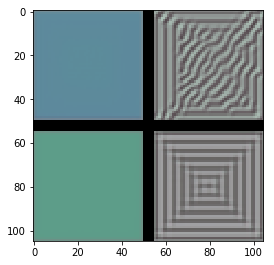

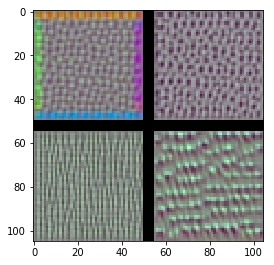

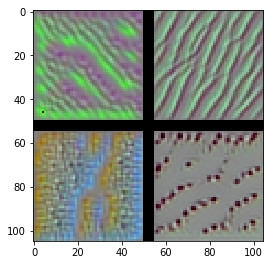

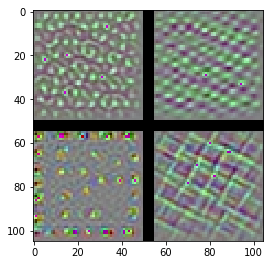

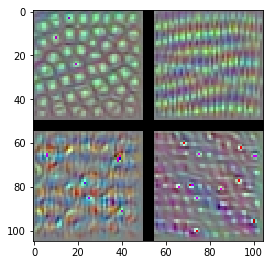

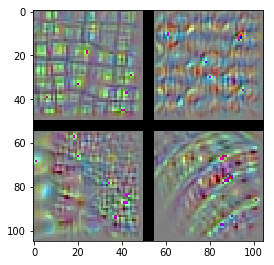

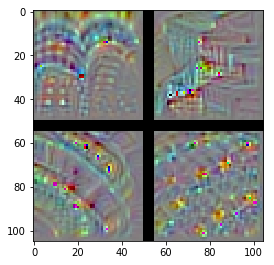

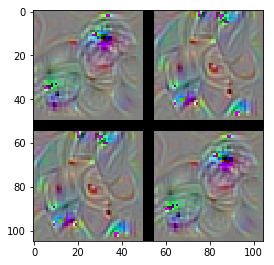

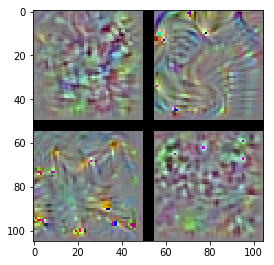

In [78]:
import matplotlib.pyplot as plt
plt.figure(figsize=(50, 50))
plt.subplot(10, 1, 1)
plt.imshow(visualize_cnn('block1_conv2'))

plt.figure(figsize=(50, 50))
plt.subplot(10, 1, 2)
plt.imshow(visualize_cnn('block2_conv1'))

plt.figure(figsize=(50, 50))
plt.subplot(10, 1, 3)
plt.imshow(visualize_cnn('block2_conv2'))

plt.figure(figsize=(50, 50))
plt.subplot(10, 1, 4)
plt.imshow(visualize_cnn('block3_conv1'))

plt.figure(figsize=(50, 50))
plt.subplot(10, 1, 5)
plt.imshow(visualize_cnn('block3_conv2'))

plt.figure(figsize=(50, 50))
plt.subplot(10, 1, 6)
plt.imshow(visualize_cnn('block4_conv1'))

plt.figure(figsize=(50, 50))
plt.subplot(10, 1, 7)
plt.imshow(visualize_cnn('block4_conv2'))

plt.figure(figsize=(50, 50))
plt.subplot(10, 1, 8)
plt.imshow(visualize_cnn('block5_conv1'))

plt.figure(figsize=(50, 50))
plt.subplot(10, 1, 9)
plt.imshow(visualize_cnn('block5_conv2'))
plt.show()

In [ ]:
'''Deep Dreaming in Keras.

Run the script with:
```
python deep_dream.py path_to_your_base_image.jpg prefix_for_results
```
e.g.:
```
python deep_dream.py img/mypic.jpg results/dream
```
'''
from __future__ import print_function

from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
import scipy
import argparse

from keras.applications import inception_v3
from keras import backend as K

base_image_path = 'test.jpg'
result_prefix = 'result'

# These are the names of the layers
# for which we try to maximize activation,
# as well as their weight in the final loss
# we try to maximize.
# You can tweak these setting to obtain new visual effects.
settings = {
    'features': {
        'mixed2': 0.2,
        'mixed3': 0.5,
        'mixed4': 2.,
        'mixed5': 1.5,
    },
}


def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = load_img(image_path)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

K.set_learning_phase(0)

# Build the InceptionV3 network with our placeholder.
# The model will be loaded with pre-trained ImageNet weights.
model = inception_v3.InceptionV3(weights='imagenet',
                                 include_top=False)
dream = model.input
print('Model loaded.')

# Get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# Define the loss.
loss = K.variable(0.)
for layer_name in settings['features']:
    # Add the L2 norm of the features of a layer to the loss.
    if layer_name not in layer_dict:
        raise ValueError('Layer ' + layer_name + ' not found in model.')
    coeff = settings['features'][layer_name]
    x = layer_dict[layer_name].output
    # We avoid border artifacts by only involving non-border pixels in the loss.
    scaling = K.prod(K.cast(K.shape(x), 'float32'))
    if K.image_data_format() == 'channels_first':
        loss += coeff * K.sum(K.square(x[:, :, 2: -2, 2: -2])) / scaling
    else:
        loss += coeff * K.sum(K.square(x[:, 2: -2, 2: -2, :])) / scaling

# Compute the gradients of the dream wrt the loss.
grads = K.gradients(loss, dream)[0]
# Normalize gradients.
grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon())

# Set up function to retrieve the value
# of the loss and gradients given an input image.
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)


def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values


def resize_img(img, size):
    img = np.copy(img)
    if K.image_data_format() == 'channels_first':
        factors = (1, 1,
                   float(size[0]) / img.shape[2],
                   float(size[1]) / img.shape[3])
    else:
        factors = (1,
                   float(size[0]) / img.shape[1],
                   float(size[1]) / img.shape[2],
                   1)
    return scipy.ndimage.zoom(img, factors, order=1)


def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('..Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x


"""Process:

- Load the original image.
- Define a number of processing scales (i.e. image shapes),
    from smallest to largest.
- Resize the original image to the smallest scale.
- For every scale, starting with the smallest (i.e. current one):
    - Run gradient ascent
    - Upscale image to the next scale
    - Reinject the detail that was lost at upscaling time
- Stop when we are back to the original size.

To obtain the detail lost during upscaling, we simply
take the original image, shrink it down, upscale it,
and compare the result to the (resized) original image.
"""


# Playing with these hyperparameters will also allow you to achieve new effects
step = 0.01  # Gradient ascent step size
num_octave = 3  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 20  # Number of ascent steps per scale
max_loss = 10.

img = preprocess_image(base_image_path)
if K.image_data_format() == 'channels_first':
    original_shape = img.shape[2:]
else:
    original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)

img.show()
#save_img(result_prefix + '.png', deprocess_image(np.copy(img)))

for i in range(len(VGG13_model.layers)):
               print(VGG13_model.layers[i].output)

### start training VGG-13

In [ ]:
history = VGG13_model.fit(data_train, label_train, batch_size=32, epochs=10, validation_split=0.1)#validation_data=(data_valid, label_valid)

### evaluate trained VGG-13 model

In [ ]:
score, acc = VGG13_model.evaluate(data_test, label_test, batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)

In [ ]:
plot_history(history)

In [ ]:
from keras import backend as K
layer = 'block1_conv2'
index = 0

layer_output = VGG13_model.layers[1].output
loss = K.mean(layer_output[:,:,:, index])

grads = K.gradients(loss, data_train[0,:])
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
iterate = K.function([input_img], [loss, grads])


# LeNet-5 implemented in keras

![LeNet-5](https://cdn-images-1.medium.com/max/1500/1*1TI1aGBZ4dybR6__DI9dzA.png)

In [ ]:
LeNet5_model = Sequential()

#  input dimension is (dim, dim, 3)
#  block 1: Conv + Maxpool
# 3 -> 6 feature maps
LeNet5_model.add(Conv2D(6, (3,3), activation='relu', padding='valid', input_shape=(dim, dim, 3), name='block1_conv1'))
LeNet5_model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2), name='block1_pool'))

# block 2: Conv + Maxpool
# 6 -> 16 feature maps
LeNet5_model.add(Conv2D(16, (3,3), activation='relu', padding='same', name='block2_conv1'))
LeNet5_model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2), name='block2_pool'))

# block 3: 3x FC
LeNet5_model.add(Flatten(name='block6_flatten'))
LeNet5_model.add(Dense(120, activation='relu', name='block3_fc1'))
LeNet5_model.add(Dense(84, activation='relu', name='block3_fc2'))
LeNet5_model.add(Dense(2, activation='sigmoid', name='predictions')) # output two classes

### compile LeNet-5 architecture

In [ ]:
# optimizer
# Adam
# AdaDelta
# SGD
LeNet5_model.compile(optimizer='AdaDelta', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
data_train.shape

In [ ]:
for i in range(len(LeNet5_model.layers)):
               print(LeNet5_model.layers[i].output)

### start training LeNet-5

In [ ]:
history = LeNet5_model.fit(data_train, label_train, batch_size=32, epochs=10, validation_split=0.1)#validation_data=(data_valid, label_valid)

### evaluate trained LeNet-5 model

In [ ]:
score, acc = LeNet5_model.evaluate(data_test, label_test, batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)

In [ ]:
plot_history(history)